In [1]:
from soil.agents import FSM, state, default_state
from soil import Environment
from random import random, shuffle, sample
from itertools import islice
import logging
from enum import Enum
from random import randint
from soil import simulation
from soil import *
import soil
import networkx as nx
import matplotlib.pyplot as plt
import logging
import random
import numpy
logging.basicConfig()


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
class Genders(Enum):
    male = 'male'
    female = 'female'

class Venues(Enum):
    pub = 'pub'
    disco = 'disco'
    street = 'street'


class CityPubs(Environment):

    """
    The environment is key in a simulation. It contains the network topology,
    a reference to network and environment agents, as well as the environment
    params, which are used as shared state between agents.
    The environment parameters and the state of every agent can be accessed
    both by using the environment as a dictionary or with the environment's 
    :meth:`soil.environment.Environment.get` method.
    'name': 'The awesome pub #{}'.format(i),
                'open': True,
                'capacity': pub_capacity ,
                'occupancy': 0,
                'price':randint(4, 6),
                'type': Venues.pub.value,
    """

  
    level = logging.INFO

   


    def __init__(self, *args, pubs=None, **kwargs):
        super(CityPubs, self).__init__(*args, **kwargs)  #Para la clase superior. Constructor super.

            
        self['pubs'] = pubs or {}

        """ >>> tel = {'jack': 4098, 'sape': 4139}
            >>> tel['guido'] = 4127    
            >>> tel
            {'sape': 4139, 'guido': 4127, 'jack': 4098}"""

        #Hacemos un bucle y llenamos la variable pubs con los bares que va a haber: queda así:
            #{'The awesome pub #2': {'name': 'The awesome pub #2', 'open': True, 'capacity': 10, 'occupancy': 0}, 
            # 'The awesome pub #1': {'name': 'The awesome pub #1', 'open': True, 'capacity': 10, 'occupancy': 0}, 
            # 'The awesome pub #0': {'name': 'The awesome pub #0', 'open': True, 'capacity': 10, 'occupancy': 0}}


   
   

    def return_occupancy (self,pub_name):
        pub = self['pubs'][pub_name]
        return pub['occupancy']

    def return_price(self,pub_name):
        pub = self['pubs'][pub_name]
        return pub['price']

    def return_name(self,pub_name):
        pub = self['pubs'][pub_name]
        return pub['name']

    def return_type(self,pub_name):
        pub = self['pubs'][pub_name]
        return pub['type']

    def enter(self, pub_name, *nodes):

        '''Agents will try to enter. The pub checks if it is possible'''
        #A este método se le pasa el id del pub al que quieren entrar, y el grupo de amigos.
        #Hace comprobaciones con la capacidad y viendo si está abierto. Devuelve True si se puede entrar.

        try:
            pub = self['pubs'][pub_name]
        except KeyError:
            raise ValueError('Pub {} is not available'.format(pub_name))

        for node in nodes:
            if not pub['open'] or (pub['capacity'] < (len(nodes) + pub['occupancy'])) or node['money']< pub['entry']:

                return False

        pub['occupancy'] += len(nodes)
        for node in nodes:
            node['pub'] = pub_name
            node['money'] = node['money'] - pub['entry']
        return True


    #Devuelve una lista de pubs en los que se puede entrar. Lo hace con yield: se genera un objeto en vez de 
    # una lista. Cuando se llama al método no se genera la lista, se genera un objeto. SOlo cuando intentemos recorrerlo
    # se generará una lista que además solo puede recorrerse una vez --> https://stackoverflow.com/questions/231767/what-does-the-yield-keyword-do
    """def available_pubs(self):
                    
                    for pub in self['pubs'].values():
                        if pub['open'] and (pub['occupancy'] < pub['capacity']):
                            yield pub['name']"""

    def available_pubs_total(self):
        available_venues = []
        for pub in self['pubs'].values():
            if pub['open'] and (pub['occupancy'] < pub['capacity']):
                available_venues.append(pub['name'])

        shuffle(available_venues)
        return available_venues 

    def available_pubs(self):
        available_venues = []
        for pub in self['pubs'].values():
            if pub['open'] and (pub['occupancy'] < pub['capacity']) and pub['type'] == "pub":
                available_venues.append(pub['name'])

        shuffle(available_venues)
        return available_venues 

    def available_discos(self):
        available_venues = []
        for pub in self['pubs'].values():
            if pub['open'] and (pub['occupancy'] < pub['capacity']) and pub['type'] == "disco":
                available_venues.append(pub['name'])

        shuffle(available_venues)
        return available_venues 

    def available_street(self):
        available_venues = []
        for pub in self['pubs'].values():
            if pub['open'] and (pub['occupancy'] < pub['capacity']) and pub['type'] == "street":
                available_venues.append(pub['name'])

        shuffle(available_venues)
        return available_venues 

    #Un grupo se va de un pub. La sintaxis "del" es como decir que te vacíe esa variable
    """def exit(self, pub_id, *node_ids):
                    '''Agents will notify the pub they want to leave'''
                    try:
                        pub = self['pubs'][pub_id]
                    except KeyError:
                        raise ValueError('Pub {} is not available'.format(pub_id))
                    for node_id in node_ids:
                        node = self.get_agent(node_id)
                        if pub_id == node['pub']:
                            del node['pub']
                            pub['occupancy'] -= 1
            
                def exit(self, pub_id, *nodes):
                    '''Agents will notify the pub they want to leave'''
                    try:
                        pub = self['pubs'][pub_id]
                    except KeyError:
                        raise ValueError('Pub {} is not available'.format(pub_id))
                    for node in nodes:
                     
                        if pub_id == node['pub']:
                            del node['pub']
                            pub['occupancy'] -= 1
            """
    def exit(self, pub_name, *nodes):

        try:
            pub = self['pubs'][pub_name]
        except KeyError:
            raise ValueError('Pub {} is not available'.format(pub_name))
        
        pub['occupancy'] -= len(nodes)
        
        


In [3]:
class Patron(FSM):
    '''Agent that looks for friends to drink with. It will do three things:
        1) Look for other patrons to drink with
        2) Look for a bar where the agent and other agents in the same group can get in.
        3) While in the bar, patrons only drink, until they get drunk and taken home.
    '''
    level = logging.INFO

    defaults = {
        'pub': None,
        'drunk': False,
        'pints': 0,
        'max_pints': 5,
        'in_a_group':False,
        'gender': Genders.male.value,
        'money':20,
        'is_leader': False,
        'group_size':0,
        'total_changes':0,
        'num_of_changes':0,
        'age': 15,
        'altercation_drinkthreshold': 12,
        'intoxicated': False,
        ##'interval'
    }

    


    @default_state
    @state
    def looking_for_friends(self):
        '''Look for friends to drink with'''
        #Dependiendo de la edad podemos hacerles algunas asignaciones de parámetros de esta manera, ya que en el otro
        #lado no se le puede meter código
        if self['age'] == 15:
            self['money'] = randint(17,23) #EN un futuro aquí se pone self['money'] = numpy.random.normal(20) o algo así imaginemos
        elif self['age'] == 20:
            self['money'] = randint(22,27)
        else:
            self['money']=randint(32,40)

        if(self['in_a_group'] == False):
            self.info('I am looking for friends')
            self['is_leader'] = True
            self['num_of_changes'] = int(numpy.random.normal(5.9,2))
            available_friends = list(self.get_agents(drunk=False,
                                                     pub=None,
                                                     in_a_group=False,
                                                     age=self['age']))
                                                     
            if not available_friends or len(available_friends)==1:
                self.info('Life sucks and I\'m alone!')
                return self.at_home
            befriended = self.try_friends(available_friends)
            if befriended:
                
                return self.looking_for_pub#, self.env.timeout(3)
        else:
            self.info('{} has a group already' .format(self.id))
            return self.looking_for_pub

    @state
    def looking_for_pub(self):
        '''Look for a pub that accepts me and my friends'''
        if self['pub'] != None:
            return self.sober_in_pub
        self.debug('I am looking for a pub')
        group = list(self.get_neighboring_agents())

        r = random()


        # ESTO DEPENDE DE LOS ITINERARIOS
        # TENDRÁ QUE EMPEZAR CADA UNO EN UN SITIO DEPENDIENDO DE LA EDAD Y LUEGO SIGUEN INTINERARIOS FIJOS
        # CON UNA CIERTA PROBABILIDAD

        #Preguntar como se ponen estas probabilidades en base a los estudios

        if(self['age'] == 15):

            if (0.4>r):
                available_pubs = self.env.available_pubs()
                

            elif (0.75>r):
                available_pubs = self.env.available_discos()

            else:
                available_pubs = self.env.available_street()

        elif(self['age'] == 20):

            if (0.5>r):
                available_pubs = self.env.available_pubs()
                



            elif (0.8>r):
                available_pubs = self.env.available_discos()

            else:
                available_pubs = self.env.available_street()

        else:

            if (0.6>r):
                available_pubs = self.env.available_pubs()
                

            elif (0.9>r):
                available_pubs = self.env.available_discos()

            else:
                available_pubs = self.env.available_street()



        for pub in available_pubs:
            
           
            self.debug('We\'re trying to get into {}: total: {}'.format(pub, len(group)))
            if self.env.enter(pub, self, *group):
                self.info('We\'re all {} getting in {}!'.format(len(group)+1, pub))
                capacity = self.env.return_occupancy(pub)
                self.info('{} now has {} people inside'.format(pub,capacity))
                return self.sober_in_pub
            else:
                self.info("We can\'t go inside {}".format(pub))

    @state
    def sober_in_pub(self):
      

        type = self.env.return_type(self['pub'])


        # ESTO DEPENDE DE LOS ITINERARIOS, QUITAR NUM_OF_CHANGES?
      
        if(type=="disco"):
            self['prob_change_bar'] = 0.01


        else:
            #Street o pub 
            self['prob_change_bar'] = 0.4


        if self['is_leader'] and (self['prob_change_bar']>random() and self['total_changes']<self['num_of_changes']):
            self.change_bar()
            self['total_changes'] = self['total_changes']  + 1



        '''Drink up.'''
        self.drink()
        if self['pints'] > self['max_pints']:
            self['drunk'] = True
            self.info('I\'m so drunk.')
            return self.drunk_in_pub

    @state
    def drunk_in_pub(self):
        
        #Cuando están borrachos, NO se van a casa, pero pueden tener altercados. Coma etilico (o intoxicacion), pelea o violencia verbal
        #, vandalismo
        #Tanbien puede cambiar de bar. Comprobar lo mismo que en sober pero
        #cambiando parámetros
        
        
        self.drink()

        if self['pints'] > self['altercation_drinkthreshold']:
            self.info('I got intoxicated')
            self['intoxicated'] = True
            return self.at_home

        #UNA VEZ BORRACHOS SU PROBABILIDAD DE ALTERCADOS SUBE, MIRAR COMO PONER LA PROBABILIDAD DE PELEAS
        # Y COMAS ETILICOS INICIAL EN LOS ESTUDIOS
      # out drunk

    @state
    def at_home(self):
        '''The end'''
        self.debug('Life sucks. I\'m home!')
    



    def change_bar(self):
        self.info('This member is going to change pub: {}'.format(self.id))

        current_pub = self['pub']
        type = self.env.return_type(self['pub'])

        group = list(self.get_neighboring_agents())
        r= random()

        #ITINERARIOS AQUÍ. SI ESTABAN EN UN BAR PASAN A UN BAR, SI ESTÁN EN DISCOTECA PASAN A OTRA O A UN BAR, SI ESTAN EN
        #BOTELLON PASAN A BAR O A DISCO

        if(type== "disco"):

            available_pubs = self.env.available_discos()


        elif(type== "pub"):

            """if (0.8>r):"""
            available_pubs = self.env.available_pubs()

            """else:
                                                    available_pubs = self.env.available_discos()"""
            """Ahora no hay gente que vaya de bar a disco"""

        else:

            if (0.5>r):
                available_pubs = self.env.available_pubs()

            else:
                available_pubs = self.env.available_discos()

        

        for pub in available_pubs:
            if self.env.return_name(pub) != current_pub:
                self.debug('We\'re trying to get into {}: total: {}'.format(pub, len(group)))
                if self.env.enter(pub, self, *group):
                    self.env.exit(current_pub,self, *group)
                    self.info('We\'re all {} changing to {}!'.format(len(group)+1, pub))
                    capacity = self.env.return_occupancy(pub)
                    self.info('{} now has {} people inside'.format(pub,capacity))
                    
                    return
                    
                else:
                    self.info("We can\'t go inside {}".format(pub))
                    #Pues buscan otra opcion
        



    
    def drink(self):
        price = self.env.return_price(self['pub'])
        if(self['prob_drink']>random() and price<self['money']):
            self['pints'] = self['pints'] + 1
            self['money'] = self['money'] -  price
            self.info('Cheers to that')
            
            self.debug('The price is {} € at {}'.format(price,self['pub']))

    def kick_out(self):
        self.set_state(self.at_home)

    def befriend(self, other_agent):
        '''
        Try to become friends with another agent. The chances of
        success depend on both agents' openness.
        '''
       
        self.env.add_edge(self, other_agent)
        self.info('Made some friend, agent {}'.format(other_agent.id))
        return True
        

    def try_friends(self, others):
        ''' Look for random agents around me and try to befriend them'''
        n=1
        befriended = False
        k = numpy.random.poisson(5.69)#k = randint(4, 6)
        shuffle(others)
        for friend in islice(others, k):  # random.choice >= 3.7
            if friend == self:
                continue
            if friend.befriend(self):
                self.befriend(friend)
                self.info('Hooray! new friend: {}'.format(friend.id))
                n = n+1
                befriended = True
            else:
                self.info('{} does not want to be friends'.format(friend.id))

        self['in_a_group'] = True
        self['group_size'] = n
        neighbors_leader = list(self.get_neighboring_agents())

        #print(*neighbors_leader)
        
        for people in neighbors_leader:
            people['in_a_group'] = True
            people['group_size'] = n
            for i in neighbors_leader:
                if (people!=i):
                    people.befriend(i)
        
        return befriended

In [4]:
class Police(FSM):
    '''Simple agent to take drunk people out of pubs.'''
    level = logging.INFO

    @default_state
    @state
    def patrol(self):
        #Echará a los que tienen altercados en un local
        intoxicates = list(self.get_agents(intoxicated=True,
                                          state_id=Patron.drunk_in_pub.id))
        for intoxicate in intoxicates:
            self.info('Kicking out the intoxicated agents: {}'.format(intoxicate.id))
            intoxicate.kick_out()
        else:
            self.info('No trash to take out. Too bad.')


In [5]:
simulation.run_from_config('pubcrawl.yml',
                               
                               dump=None,
                               )



INFO:soil:Using config(s): Malasana
INFO:soil:Dumping results to soil_output/Malasana : False
INFO:soil:Starting simulation Malasana at 12:53:39.
INFO:soil:Starting Simulation Malasana trial 0 at 12:53:51.
INFO:Malasana_trial_0-Agent-Police:	@    0:	No trash to take out. Too bad.
INFO:Malasana_trial_0-Agent-0:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-244:	@    0:	Made some friend, agent 0
INFO:Malasana_trial_0-Agent-0:	@    0:	Made some friend, agent 244
INFO:Malasana_trial_0-Agent-0:	@    0:	Hooray! new friend: 244
INFO:Malasana_trial_0-Agent-264:	@    0:	Made some friend, agent 0
INFO:Malasana_trial_0-Agent-0:	@    0:	Made some friend, agent 264
INFO:Malasana_trial_0-Agent-0:	@    0:	Hooray! new friend: 264
INFO:Malasana_trial_0-Agent-310:	@    0:	Made some friend, agent 0
INFO:Malasana_trial_0-Agent-0:	@    0:	Made some friend, agent 310
INFO:Malasana_trial_0-Agent-0:	@    0:	Hooray! new friend: 310
INFO:Malasana_trial_0-Agent-137:	@    0:	Made some friend, agent

INFO:Malasana_trial_0-Agent-44:	@    0:	Made some friend, agent 16
INFO:Malasana_trial_0-Agent-44:	@    0:	Made some friend, agent 215
INFO:Malasana_trial_0-Agent-44:	@    0:	Made some friend, agent 312
INFO:Malasana_trial_0-Agent-44:	@    0:	Made some friend, agent 378
INFO:Malasana_trial_0-Agent-44:	@    0:	Made some friend, agent 368
INFO:Malasana_trial_0-Agent-368:	@    0:	Made some friend, agent 320
INFO:Malasana_trial_0-Agent-368:	@    0:	Made some friend, agent 209
INFO:Malasana_trial_0-Agent-368:	@    0:	Made some friend, agent 16
INFO:Malasana_trial_0-Agent-368:	@    0:	Made some friend, agent 215
INFO:Malasana_trial_0-Agent-368:	@    0:	Made some friend, agent 312
INFO:Malasana_trial_0-Agent-368:	@    0:	Made some friend, agent 378
INFO:Malasana_trial_0-Agent-368:	@    0:	Made some friend, agent 44
INFO:Malasana_trial_0-Agent-2:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-179:	@    0:	Made some friend, agent 2
INFO:Malasana_trial_0-Agent-2:	@    0:	Made some 

INFO:Malasana_trial_0-Agent-59:	@    0:	Made some friend, agent 67
INFO:Malasana_trial_0-Agent-59:	@    0:	Made some friend, agent 171
INFO:Malasana_trial_0-Agent-59:	@    0:	Made some friend, agent 375
INFO:Malasana_trial_0-Agent-59:	@    0:	Made some friend, agent 361
INFO:Malasana_trial_0-Agent-59:	@    0:	Made some friend, agent 76
INFO:Malasana_trial_0-Agent-59:	@    0:	Made some friend, agent 239
INFO:Malasana_trial_0-Agent-76:	@    0:	Made some friend, agent 67
INFO:Malasana_trial_0-Agent-76:	@    0:	Made some friend, agent 171
INFO:Malasana_trial_0-Agent-76:	@    0:	Made some friend, agent 375
INFO:Malasana_trial_0-Agent-76:	@    0:	Made some friend, agent 361
INFO:Malasana_trial_0-Agent-76:	@    0:	Made some friend, agent 59
INFO:Malasana_trial_0-Agent-76:	@    0:	Made some friend, agent 239
INFO:Malasana_trial_0-Agent-239:	@    0:	Made some friend, agent 67
INFO:Malasana_trial_0-Agent-239:	@    0:	Made some friend, agent 171
INFO:Malasana_trial_0-Agent-239:	@    0:	Made some 

INFO:Malasana_trial_0-Agent-7:	@    0:	Hooray! new friend: 87
INFO:Malasana_trial_0-Agent-90:	@    0:	Made some friend, agent 7
INFO:Malasana_trial_0-Agent-7:	@    0:	Made some friend, agent 90
INFO:Malasana_trial_0-Agent-7:	@    0:	Hooray! new friend: 90
INFO:Malasana_trial_0-Agent-90:	@    0:	Made some friend, agent 87
INFO:Malasana_trial_0-Agent-87:	@    0:	Made some friend, agent 90
INFO:Malasana_trial_0-Agent-8:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-325:	@    0:	Made some friend, agent 8
INFO:Malasana_trial_0-Agent-8:	@    0:	Made some friend, agent 325
INFO:Malasana_trial_0-Agent-8:	@    0:	Hooray! new friend: 325
INFO:Malasana_trial_0-Agent-256:	@    0:	Made some friend, agent 8
INFO:Malasana_trial_0-Agent-8:	@    0:	Made some friend, agent 256
INFO:Malasana_trial_0-Agent-8:	@    0:	Hooray! new friend: 256
INFO:Malasana_trial_0-Agent-286:	@    0:	Made some friend, agent 8
INFO:Malasana_trial_0-Agent-8:	@    0:	Made some friend, agent 286
INFO:Malasana_tria

INFO:Malasana_trial_0-Agent-69:	@    0:	Made some friend, agent 343
INFO:Malasana_trial_0-Agent-69:	@    0:	Made some friend, agent 163
INFO:Malasana_trial_0-Agent-69:	@    0:	Made some friend, agent 156
INFO:Malasana_trial_0-Agent-69:	@    0:	Made some friend, agent 111
INFO:Malasana_trial_0-Agent-343:	@    0:	Made some friend, agent 176
INFO:Malasana_trial_0-Agent-343:	@    0:	Made some friend, agent 323
INFO:Malasana_trial_0-Agent-343:	@    0:	Made some friend, agent 69
INFO:Malasana_trial_0-Agent-343:	@    0:	Made some friend, agent 163
INFO:Malasana_trial_0-Agent-343:	@    0:	Made some friend, agent 156
INFO:Malasana_trial_0-Agent-343:	@    0:	Made some friend, agent 111
INFO:Malasana_trial_0-Agent-163:	@    0:	Made some friend, agent 176
INFO:Malasana_trial_0-Agent-163:	@    0:	Made some friend, agent 323
INFO:Malasana_trial_0-Agent-163:	@    0:	Made some friend, agent 69
INFO:Malasana_trial_0-Agent-163:	@    0:	Made some friend, agent 343
INFO:Malasana_trial_0-Agent-163:	@    0:

INFO:Malasana_trial_0-Agent-108:	@    0:	Made some friend, agent 337
INFO:Malasana_trial_0-Agent-108:	@    0:	Made some friend, agent 82
INFO:Malasana_trial_0-Agent-108:	@    0:	Made some friend, agent 212
INFO:Malasana_trial_0-Agent-108:	@    0:	Made some friend, agent 280
INFO:Malasana_trial_0-Agent-108:	@    0:	Made some friend, agent 276
INFO:Malasana_trial_0-Agent-108:	@    0:	Made some friend, agent 122
INFO:Malasana_trial_0-Agent-108:	@    0:	Made some friend, agent 316
INFO:Malasana_trial_0-Agent-108:	@    0:	Made some friend, agent 253
INFO:Malasana_trial_0-Agent-337:	@    0:	Made some friend, agent 227
INFO:Malasana_trial_0-Agent-337:	@    0:	Made some friend, agent 103
INFO:Malasana_trial_0-Agent-337:	@    0:	Made some friend, agent 297
INFO:Malasana_trial_0-Agent-337:	@    0:	Made some friend, agent 74
INFO:Malasana_trial_0-Agent-337:	@    0:	Made some friend, agent 108
INFO:Malasana_trial_0-Agent-337:	@    0:	Made some friend, agent 82
INFO:Malasana_trial_0-Agent-337:	@   

INFO:Malasana_trial_0-Agent-200:	@    0:	Made some friend, agent 12
INFO:Malasana_trial_0-Agent-12:	@    0:	Made some friend, agent 200
INFO:Malasana_trial_0-Agent-12:	@    0:	Hooray! new friend: 200
INFO:Malasana_trial_0-Agent-35:	@    0:	Made some friend, agent 12
INFO:Malasana_trial_0-Agent-12:	@    0:	Made some friend, agent 35
INFO:Malasana_trial_0-Agent-12:	@    0:	Hooray! new friend: 35
INFO:Malasana_trial_0-Agent-390:	@    0:	Made some friend, agent 12
INFO:Malasana_trial_0-Agent-12:	@    0:	Made some friend, agent 390
INFO:Malasana_trial_0-Agent-12:	@    0:	Hooray! new friend: 390
INFO:Malasana_trial_0-Agent-385:	@    0:	Made some friend, agent 12
INFO:Malasana_trial_0-Agent-12:	@    0:	Made some friend, agent 385
INFO:Malasana_trial_0-Agent-12:	@    0:	Hooray! new friend: 385
INFO:Malasana_trial_0-Agent-231:	@    0:	Made some friend, agent 12
INFO:Malasana_trial_0-Agent-12:	@    0:	Made some friend, agent 231
INFO:Malasana_trial_0-Agent-12:	@    0:	Hooray! new friend: 231
INF

INFO:Malasana_trial_0-Agent-154:	@    0:	Made some friend, agent 385
INFO:Malasana_trial_0-Agent-154:	@    0:	Made some friend, agent 35
INFO:Malasana_trial_0-Agent-154:	@    0:	Made some friend, agent 228
INFO:Malasana_trial_0-Agent-154:	@    0:	Made some friend, agent 102
INFO:Malasana_trial_0-Agent-154:	@    0:	Made some friend, agent 390
INFO:Malasana_trial_0-Agent-154:	@    0:	Made some friend, agent 231
INFO:Malasana_trial_0-Agent-154:	@    0:	Made some friend, agent 200
INFO:Malasana_trial_0-Agent-154:	@    0:	Made some friend, agent 112
INFO:Malasana_trial_0-Agent-154:	@    0:	Made some friend, agent 232
INFO:Malasana_trial_0-Agent-154:	@    0:	Made some friend, agent 60
INFO:Malasana_trial_0-Agent-154:	@    0:	Made some friend, agent 318
INFO:Malasana_trial_0-Agent-60:	@    0:	Made some friend, agent 385
INFO:Malasana_trial_0-Agent-60:	@    0:	Made some friend, agent 35
INFO:Malasana_trial_0-Agent-60:	@    0:	Made some friend, agent 228
INFO:Malasana_trial_0-Agent-60:	@    0:	

INFO:Malasana_trial_0-Agent-120:	@    0:	Made some friend, agent 303
INFO:Malasana_trial_0-Agent-157:	@    0:	Made some friend, agent 180
INFO:Malasana_trial_0-Agent-157:	@    0:	Made some friend, agent 21
INFO:Malasana_trial_0-Agent-157:	@    0:	Made some friend, agent 342
INFO:Malasana_trial_0-Agent-157:	@    0:	Made some friend, agent 279
INFO:Malasana_trial_0-Agent-157:	@    0:	Made some friend, agent 120
INFO:Malasana_trial_0-Agent-157:	@    0:	Made some friend, agent 303
INFO:Malasana_trial_0-Agent-303:	@    0:	Made some friend, agent 180
INFO:Malasana_trial_0-Agent-303:	@    0:	Made some friend, agent 21
INFO:Malasana_trial_0-Agent-303:	@    0:	Made some friend, agent 342
INFO:Malasana_trial_0-Agent-303:	@    0:	Made some friend, agent 279
INFO:Malasana_trial_0-Agent-303:	@    0:	Made some friend, agent 120
INFO:Malasana_trial_0-Agent-303:	@    0:	Made some friend, agent 157
INFO:Malasana_trial_0-Agent-16:	@    0:	16 has a group already
INFO:Malasana_trial_0-Agent-17:	@    0:	I 

INFO:Malasana_trial_0-Agent-22:	@    0:	Hooray! new friend: 160
INFO:Malasana_trial_0-Agent-96:	@    0:	Made some friend, agent 22
INFO:Malasana_trial_0-Agent-22:	@    0:	Made some friend, agent 96
INFO:Malasana_trial_0-Agent-22:	@    0:	Hooray! new friend: 96
INFO:Malasana_trial_0-Agent-249:	@    0:	Made some friend, agent 22
INFO:Malasana_trial_0-Agent-22:	@    0:	Made some friend, agent 249
INFO:Malasana_trial_0-Agent-22:	@    0:	Hooray! new friend: 249
INFO:Malasana_trial_0-Agent-313:	@    0:	Made some friend, agent 22
INFO:Malasana_trial_0-Agent-22:	@    0:	Made some friend, agent 313
INFO:Malasana_trial_0-Agent-22:	@    0:	Hooray! new friend: 313
INFO:Malasana_trial_0-Agent-319:	@    0:	Made some friend, agent 22
INFO:Malasana_trial_0-Agent-22:	@    0:	Made some friend, agent 319
INFO:Malasana_trial_0-Agent-22:	@    0:	Hooray! new friend: 319
INFO:Malasana_trial_0-Agent-98:	@    0:	Made some friend, agent 22
INFO:Malasana_trial_0-Agent-22:	@    0:	Made some friend, agent 98
INFO:

INFO:Malasana_trial_0-Agent-131:	@    0:	Made some friend, agent 208
INFO:Malasana_trial_0-Agent-131:	@    0:	Made some friend, agent 245
INFO:Malasana_trial_0-Agent-131:	@    0:	Made some friend, agent 214
INFO:Malasana_trial_0-Agent-131:	@    0:	Made some friend, agent 184
INFO:Malasana_trial_0-Agent-131:	@    0:	Made some friend, agent 206
INFO:Malasana_trial_0-Agent-131:	@    0:	Made some friend, agent 31
INFO:Malasana_trial_0-Agent-245:	@    0:	Made some friend, agent 208
INFO:Malasana_trial_0-Agent-245:	@    0:	Made some friend, agent 131
INFO:Malasana_trial_0-Agent-245:	@    0:	Made some friend, agent 214
INFO:Malasana_trial_0-Agent-245:	@    0:	Made some friend, agent 184
INFO:Malasana_trial_0-Agent-245:	@    0:	Made some friend, agent 206
INFO:Malasana_trial_0-Agent-245:	@    0:	Made some friend, agent 31
INFO:Malasana_trial_0-Agent-214:	@    0:	Made some friend, agent 208
INFO:Malasana_trial_0-Agent-214:	@    0:	Made some friend, agent 131
INFO:Malasana_trial_0-Agent-214:	@  

INFO:Malasana_trial_0-Agent-309:	@    0:	Made some friend, agent 193
INFO:Malasana_trial_0-Agent-309:	@    0:	Made some friend, agent 104
INFO:Malasana_trial_0-Agent-309:	@    0:	Made some friend, agent 266
INFO:Malasana_trial_0-Agent-309:	@    0:	Made some friend, agent 301
INFO:Malasana_trial_0-Agent-309:	@    0:	Made some friend, agent 367
INFO:Malasana_trial_0-Agent-104:	@    0:	Made some friend, agent 352
INFO:Malasana_trial_0-Agent-104:	@    0:	Made some friend, agent 193
INFO:Malasana_trial_0-Agent-104:	@    0:	Made some friend, agent 309
INFO:Malasana_trial_0-Agent-104:	@    0:	Made some friend, agent 266
INFO:Malasana_trial_0-Agent-104:	@    0:	Made some friend, agent 301
INFO:Malasana_trial_0-Agent-104:	@    0:	Made some friend, agent 367
INFO:Malasana_trial_0-Agent-266:	@    0:	Made some friend, agent 352
INFO:Malasana_trial_0-Agent-266:	@    0:	Made some friend, agent 193
INFO:Malasana_trial_0-Agent-266:	@    0:	Made some friend, agent 309
INFO:Malasana_trial_0-Agent-266:	@

INFO:Malasana_trial_0-Agent-33:	@    0:	Made some friend, agent 185
INFO:Malasana_trial_0-Agent-33:	@    0:	Hooray! new friend: 185
INFO:Malasana_trial_0-Agent-126:	@    0:	Made some friend, agent 33
INFO:Malasana_trial_0-Agent-33:	@    0:	Made some friend, agent 126
INFO:Malasana_trial_0-Agent-33:	@    0:	Hooray! new friend: 126
INFO:Malasana_trial_0-Agent-75:	@    0:	Made some friend, agent 33
INFO:Malasana_trial_0-Agent-33:	@    0:	Made some friend, agent 75
INFO:Malasana_trial_0-Agent-33:	@    0:	Hooray! new friend: 75
INFO:Malasana_trial_0-Agent-75:	@    0:	Made some friend, agent 185
INFO:Malasana_trial_0-Agent-75:	@    0:	Made some friend, agent 170
INFO:Malasana_trial_0-Agent-75:	@    0:	Made some friend, agent 283
INFO:Malasana_trial_0-Agent-75:	@    0:	Made some friend, agent 204
INFO:Malasana_trial_0-Agent-75:	@    0:	Made some friend, agent 189
INFO:Malasana_trial_0-Agent-75:	@    0:	Made some friend, agent 126
INFO:Malasana_trial_0-Agent-185:	@    0:	Made some friend, agen

INFO:Malasana_trial_0-Agent-36:	@    0:	Hooray! new friend: 192
INFO:Malasana_trial_0-Agent-369:	@    0:	Made some friend, agent 36
INFO:Malasana_trial_0-Agent-36:	@    0:	Made some friend, agent 369
INFO:Malasana_trial_0-Agent-36:	@    0:	Hooray! new friend: 369
INFO:Malasana_trial_0-Agent-237:	@    0:	Made some friend, agent 36
INFO:Malasana_trial_0-Agent-36:	@    0:	Made some friend, agent 237
INFO:Malasana_trial_0-Agent-36:	@    0:	Hooray! new friend: 237
INFO:Malasana_trial_0-Agent-255:	@    0:	Made some friend, agent 36
INFO:Malasana_trial_0-Agent-36:	@    0:	Made some friend, agent 255
INFO:Malasana_trial_0-Agent-36:	@    0:	Hooray! new friend: 255
INFO:Malasana_trial_0-Agent-183:	@    0:	Made some friend, agent 36
INFO:Malasana_trial_0-Agent-36:	@    0:	Made some friend, agent 183
INFO:Malasana_trial_0-Agent-36:	@    0:	Hooray! new friend: 183
INFO:Malasana_trial_0-Agent-143:	@    0:	Made some friend, agent 36
INFO:Malasana_trial_0-Agent-36:	@    0:	Made some friend, agent 143


INFO:Malasana_trial_0-Agent-217:	@    0:	Made some friend, agent 77
INFO:Malasana_trial_0-Agent-217:	@    0:	Made some friend, agent 95
INFO:Malasana_trial_0-Agent-202:	@    0:	Made some friend, agent 307
INFO:Malasana_trial_0-Agent-202:	@    0:	Made some friend, agent 89
INFO:Malasana_trial_0-Agent-202:	@    0:	Made some friend, agent 217
INFO:Malasana_trial_0-Agent-202:	@    0:	Made some friend, agent 363
INFO:Malasana_trial_0-Agent-202:	@    0:	Made some friend, agent 77
INFO:Malasana_trial_0-Agent-202:	@    0:	Made some friend, agent 95
INFO:Malasana_trial_0-Agent-363:	@    0:	Made some friend, agent 307
INFO:Malasana_trial_0-Agent-363:	@    0:	Made some friend, agent 89
INFO:Malasana_trial_0-Agent-363:	@    0:	Made some friend, agent 217
INFO:Malasana_trial_0-Agent-363:	@    0:	Made some friend, agent 202
INFO:Malasana_trial_0-Agent-363:	@    0:	Made some friend, agent 77
INFO:Malasana_trial_0-Agent-363:	@    0:	Made some friend, agent 95
INFO:Malasana_trial_0-Agent-77:	@    0:	Ma

INFO:Malasana_trial_0-Agent-46:	@    0:	Made some friend, agent 388
INFO:Malasana_trial_0-Agent-46:	@    0:	Hooray! new friend: 388
INFO:Malasana_trial_0-Agent-210:	@    0:	Made some friend, agent 211
INFO:Malasana_trial_0-Agent-210:	@    0:	Made some friend, agent 388
INFO:Malasana_trial_0-Agent-210:	@    0:	Made some friend, agent 166
INFO:Malasana_trial_0-Agent-210:	@    0:	Made some friend, agent 374
INFO:Malasana_trial_0-Agent-210:	@    0:	Made some friend, agent 119
INFO:Malasana_trial_0-Agent-211:	@    0:	Made some friend, agent 210
INFO:Malasana_trial_0-Agent-211:	@    0:	Made some friend, agent 388
INFO:Malasana_trial_0-Agent-211:	@    0:	Made some friend, agent 166
INFO:Malasana_trial_0-Agent-211:	@    0:	Made some friend, agent 374
INFO:Malasana_trial_0-Agent-211:	@    0:	Made some friend, agent 119
INFO:Malasana_trial_0-Agent-388:	@    0:	Made some friend, agent 210
INFO:Malasana_trial_0-Agent-388:	@    0:	Made some friend, agent 211
INFO:Malasana_trial_0-Agent-388:	@    0:

INFO:Malasana_trial_0-Agent-305:	@    0:	Made some friend, agent 373
INFO:Malasana_trial_0-Agent-373:	@    0:	Made some friend, agent 225
INFO:Malasana_trial_0-Agent-373:	@    0:	Made some friend, agent 178
INFO:Malasana_trial_0-Agent-373:	@    0:	Made some friend, agent 99
INFO:Malasana_trial_0-Agent-373:	@    0:	Made some friend, agent 293
INFO:Malasana_trial_0-Agent-373:	@    0:	Made some friend, agent 241
INFO:Malasana_trial_0-Agent-373:	@    0:	Made some friend, agent 207
INFO:Malasana_trial_0-Agent-373:	@    0:	Made some friend, agent 305
INFO:Malasana_trial_0-Agent-49:	@    0:	49 has a group already
INFO:Malasana_trial_0-Agent-50:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-261:	@    0:	Made some friend, agent 50
INFO:Malasana_trial_0-Agent-50:	@    0:	Made some friend, agent 261
INFO:Malasana_trial_0-Agent-50:	@    0:	Hooray! new friend: 261
INFO:Malasana_trial_0-Agent-219:	@    0:	Made some friend, agent 50
INFO:Malasana_trial_0-Agent-50:	@    0:	Made some fri

INFO:Malasana_trial_0-Agent-397:	@    0:	Made some friend, agent 58
INFO:Malasana_trial_0-Agent-397:	@    0:	Made some friend, agent 62
INFO:Malasana_trial_0-Agent-397:	@    0:	Made some friend, agent 294
INFO:Malasana_trial_0-Agent-397:	@    0:	Made some friend, agent 314
INFO:Malasana_trial_0-Agent-397:	@    0:	Made some friend, agent 205
INFO:Malasana_trial_0-Agent-397:	@    0:	Made some friend, agent 366
INFO:Malasana_trial_0-Agent-52:	@    0:	52 has a group already
INFO:Malasana_trial_0-Agent-53:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-254:	@    0:	Made some friend, agent 53
INFO:Malasana_trial_0-Agent-53:	@    0:	Made some friend, agent 254
INFO:Malasana_trial_0-Agent-53:	@    0:	Hooray! new friend: 254
INFO:Malasana_trial_0-Agent-54:	@    0:	54 has a group already
INFO:Malasana_trial_0-Agent-55:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-360:	@    0:	Made some friend, agent 55
INFO:Malasana_trial_0-Agent-55:	@    0:	Made some friend, agent 

INFO:Malasana_trial_0-Agent-333:	@    0:	Made some friend, agent 362
INFO:Malasana_trial_0-Agent-333:	@    0:	Made some friend, agent 114
INFO:Malasana_trial_0-Agent-62:	@    0:	62 has a group already
INFO:Malasana_trial_0-Agent-63:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-135:	@    0:	Made some friend, agent 63
INFO:Malasana_trial_0-Agent-63:	@    0:	Made some friend, agent 135
INFO:Malasana_trial_0-Agent-63:	@    0:	Hooray! new friend: 135
INFO:Malasana_trial_0-Agent-372:	@    0:	Made some friend, agent 63
INFO:Malasana_trial_0-Agent-63:	@    0:	Made some friend, agent 372
INFO:Malasana_trial_0-Agent-63:	@    0:	Hooray! new friend: 372
INFO:Malasana_trial_0-Agent-203:	@    0:	Made some friend, agent 63
INFO:Malasana_trial_0-Agent-63:	@    0:	Made some friend, agent 203
INFO:Malasana_trial_0-Agent-63:	@    0:	Hooray! new friend: 203
INFO:Malasana_trial_0-Agent-100:	@    0:	Made some friend, agent 63
INFO:Malasana_trial_0-Agent-63:	@    0:	Made some friend, agent 10

INFO:Malasana_trial_0-Agent-339:	@    0:	Made some friend, agent 372
INFO:Malasana_trial_0-Agent-339:	@    0:	Made some friend, agent 174
INFO:Malasana_trial_0-Agent-339:	@    0:	Made some friend, agent 278
INFO:Malasana_trial_0-Agent-339:	@    0:	Made some friend, agent 348
INFO:Malasana_trial_0-Agent-339:	@    0:	Made some friend, agent 158
INFO:Malasana_trial_0-Agent-339:	@    0:	Made some friend, agent 191
INFO:Malasana_trial_0-Agent-372:	@    0:	Made some friend, agent 100
INFO:Malasana_trial_0-Agent-372:	@    0:	Made some friend, agent 135
INFO:Malasana_trial_0-Agent-372:	@    0:	Made some friend, agent 138
INFO:Malasana_trial_0-Agent-372:	@    0:	Made some friend, agent 203
INFO:Malasana_trial_0-Agent-372:	@    0:	Made some friend, agent 302
INFO:Malasana_trial_0-Agent-372:	@    0:	Made some friend, agent 145
INFO:Malasana_trial_0-Agent-372:	@    0:	Made some friend, agent 339
INFO:Malasana_trial_0-Agent-372:	@    0:	Made some friend, agent 174
INFO:Malasana_trial_0-Agent-372:	@

INFO:Malasana_trial_0-Agent-347:	@    0:	Made some friend, agent 106
INFO:Malasana_trial_0-Agent-347:	@    0:	Made some friend, agent 334
INFO:Malasana_trial_0-Agent-334:	@    0:	Made some friend, agent 341
INFO:Malasana_trial_0-Agent-334:	@    0:	Made some friend, agent 150
INFO:Malasana_trial_0-Agent-334:	@    0:	Made some friend, agent 296
INFO:Malasana_trial_0-Agent-334:	@    0:	Made some friend, agent 106
INFO:Malasana_trial_0-Agent-334:	@    0:	Made some friend, agent 347
INFO:Malasana_trial_0-Agent-65:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-194:	@    0:	Made some friend, agent 65
INFO:Malasana_trial_0-Agent-65:	@    0:	Made some friend, agent 194
INFO:Malasana_trial_0-Agent-65:	@    0:	Hooray! new friend: 194
INFO:Malasana_trial_0-Agent-292:	@    0:	Made some friend, agent 65
INFO:Malasana_trial_0-Agent-65:	@    0:	Made some friend, agent 292
INFO:Malasana_trial_0-Agent-65:	@    0:	Hooray! new friend: 292
INFO:Malasana_trial_0-Agent-271:	@    0:	Made some f

INFO:Malasana_trial_0-Agent-79:	@    0:	Made some friend, agent 165
INFO:Malasana_trial_0-Agent-79:	@    0:	Made some friend, agent 234
INFO:Malasana_trial_0-Agent-79:	@    0:	Made some friend, agent 317
INFO:Malasana_trial_0-Agent-71:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-197:	@    0:	Made some friend, agent 71
INFO:Malasana_trial_0-Agent-71:	@    0:	Made some friend, agent 197
INFO:Malasana_trial_0-Agent-71:	@    0:	Hooray! new friend: 197
INFO:Malasana_trial_0-Agent-396:	@    0:	Made some friend, agent 71
INFO:Malasana_trial_0-Agent-71:	@    0:	Made some friend, agent 396
INFO:Malasana_trial_0-Agent-71:	@    0:	Hooray! new friend: 396
INFO:Malasana_trial_0-Agent-155:	@    0:	Made some friend, agent 71
INFO:Malasana_trial_0-Agent-71:	@    0:	Made some friend, agent 155
INFO:Malasana_trial_0-Agent-71:	@    0:	Hooray! new friend: 155
INFO:Malasana_trial_0-Agent-370:	@    0:	Made some friend, agent 71
INFO:Malasana_trial_0-Agent-71:	@    0:	Made some friend, agent

INFO:Malasana_trial_0-Agent-267:	@    0:	Made some friend, agent 146
INFO:Malasana_trial_0-Agent-267:	@    0:	Made some friend, agent 382
INFO:Malasana_trial_0-Agent-267:	@    0:	Made some friend, agent 221
INFO:Malasana_trial_0-Agent-267:	@    0:	Made some friend, agent 222
INFO:Malasana_trial_0-Agent-221:	@    0:	Made some friend, agent 384
INFO:Malasana_trial_0-Agent-221:	@    0:	Made some friend, agent 129
INFO:Malasana_trial_0-Agent-221:	@    0:	Made some friend, agent 146
INFO:Malasana_trial_0-Agent-221:	@    0:	Made some friend, agent 382
INFO:Malasana_trial_0-Agent-221:	@    0:	Made some friend, agent 267
INFO:Malasana_trial_0-Agent-221:	@    0:	Made some friend, agent 222
INFO:Malasana_trial_0-Agent-222:	@    0:	Made some friend, agent 384
INFO:Malasana_trial_0-Agent-222:	@    0:	Made some friend, agent 129
INFO:Malasana_trial_0-Agent-222:	@    0:	Made some friend, agent 146
INFO:Malasana_trial_0-Agent-222:	@    0:	Made some friend, agent 382
INFO:Malasana_trial_0-Agent-222:	@

INFO:Malasana_trial_0-Agent-102:	@    0:	102 has a group already
INFO:Malasana_trial_0-Agent-103:	@    0:	103 has a group already
INFO:Malasana_trial_0-Agent-104:	@    0:	104 has a group already
INFO:Malasana_trial_0-Agent-105:	@    0:	105 has a group already
INFO:Malasana_trial_0-Agent-106:	@    0:	106 has a group already
INFO:Malasana_trial_0-Agent-107:	@    0:	107 has a group already
INFO:Malasana_trial_0-Agent-108:	@    0:	108 has a group already
INFO:Malasana_trial_0-Agent-109:	@    0:	109 has a group already
INFO:Malasana_trial_0-Agent-110:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-345:	@    0:	Made some friend, agent 110
INFO:Malasana_trial_0-Agent-110:	@    0:	Made some friend, agent 345
INFO:Malasana_trial_0-Agent-110:	@    0:	Hooray! new friend: 345
INFO:Malasana_trial_0-Agent-357:	@    0:	Made some friend, agent 110
INFO:Malasana_trial_0-Agent-110:	@    0:	Made some friend, agent 357
INFO:Malasana_trial_0-Agent-110:	@    0:	Hooray! new friend: 357
INFO:Mal

INFO:Malasana_trial_0-Agent-274:	@    0:	Made some friend, agent 240
INFO:Malasana_trial_0-Agent-274:	@    0:	Made some friend, agent 338
INFO:Malasana_trial_0-Agent-274:	@    0:	Made some friend, agent 311
INFO:Malasana_trial_0-Agent-311:	@    0:	Made some friend, agent 240
INFO:Malasana_trial_0-Agent-311:	@    0:	Made some friend, agent 338
INFO:Malasana_trial_0-Agent-311:	@    0:	Made some friend, agent 274
INFO:Malasana_trial_0-Agent-125:	@    0:	125 has a group already
INFO:Malasana_trial_0-Agent-126:	@    0:	126 has a group already
INFO:Malasana_trial_0-Agent-127:	@    0:	127 has a group already
INFO:Malasana_trial_0-Agent-128:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-132:	@    0:	Made some friend, agent 128
INFO:Malasana_trial_0-Agent-128:	@    0:	Made some friend, agent 132
INFO:Malasana_trial_0-Agent-128:	@    0:	Hooray! new friend: 132
INFO:Malasana_trial_0-Agent-167:	@    0:	Made some friend, agent 128
INFO:Malasana_trial_0-Agent-128:	@    0:	Made some fr

INFO:Malasana_trial_0-Agent-262:	@    0:	Made some friend, agent 358
INFO:Malasana_trial_0-Agent-262:	@    0:	Made some friend, agent 151
INFO:Malasana_trial_0-Agent-262:	@    0:	Made some friend, agent 177
INFO:Malasana_trial_0-Agent-262:	@    0:	Made some friend, agent 235
INFO:Malasana_trial_0-Agent-262:	@    0:	Made some friend, agent 300
INFO:Malasana_trial_0-Agent-177:	@    0:	Made some friend, agent 328
INFO:Malasana_trial_0-Agent-177:	@    0:	Made some friend, agent 322
INFO:Malasana_trial_0-Agent-177:	@    0:	Made some friend, agent 181
INFO:Malasana_trial_0-Agent-177:	@    0:	Made some friend, agent 358
INFO:Malasana_trial_0-Agent-177:	@    0:	Made some friend, agent 151
INFO:Malasana_trial_0-Agent-177:	@    0:	Made some friend, agent 262
INFO:Malasana_trial_0-Agent-177:	@    0:	Made some friend, agent 235
INFO:Malasana_trial_0-Agent-177:	@    0:	Made some friend, agent 300
INFO:Malasana_trial_0-Agent-235:	@    0:	Made some friend, agent 328
INFO:Malasana_trial_0-Agent-235:	@

INFO:Malasana_trial_0-Agent-180:	@    0:	180 has a group already
INFO:Malasana_trial_0-Agent-181:	@    0:	181 has a group already
INFO:Malasana_trial_0-Agent-182:	@    0:	182 has a group already
INFO:Malasana_trial_0-Agent-183:	@    0:	183 has a group already
INFO:Malasana_trial_0-Agent-184:	@    0:	184 has a group already
INFO:Malasana_trial_0-Agent-185:	@    0:	185 has a group already
INFO:Malasana_trial_0-Agent-186:	@    0:	186 has a group already
INFO:Malasana_trial_0-Agent-187:	@    0:	187 has a group already
INFO:Malasana_trial_0-Agent-188:	@    0:	188 has a group already
INFO:Malasana_trial_0-Agent-189:	@    0:	189 has a group already
INFO:Malasana_trial_0-Agent-190:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-251:	@    0:	Made some friend, agent 190
INFO:Malasana_trial_0-Agent-190:	@    0:	Made some friend, agent 251
INFO:Malasana_trial_0-Agent-190:	@    0:	Hooray! new friend: 251
INFO:Malasana_trial_0-Agent-299:	@    0:	Made some friend, agent 190
INFO:Malasan

INFO:Malasana_trial_0-Agent-274:	@    0:	274 has a group already
INFO:Malasana_trial_0-Agent-275:	@    0:	275 has a group already
INFO:Malasana_trial_0-Agent-276:	@    0:	276 has a group already
INFO:Malasana_trial_0-Agent-277:	@    0:	277 has a group already
INFO:Malasana_trial_0-Agent-278:	@    0:	278 has a group already
INFO:Malasana_trial_0-Agent-279:	@    0:	279 has a group already
INFO:Malasana_trial_0-Agent-280:	@    0:	280 has a group already
INFO:Malasana_trial_0-Agent-281:	@    0:	I am looking for friends
INFO:Malasana_trial_0-Agent-306:	@    0:	Made some friend, agent 281
INFO:Malasana_trial_0-Agent-281:	@    0:	Made some friend, agent 306
INFO:Malasana_trial_0-Agent-281:	@    0:	Hooray! new friend: 306
INFO:Malasana_trial_0-Agent-377:	@    0:	Made some friend, agent 281
INFO:Malasana_trial_0-Agent-281:	@    0:	Made some friend, agent 377
INFO:Malasana_trial_0-Agent-281:	@    0:	Hooray! new friend: 377
INFO:Malasana_trial_0-Agent-377:	@    0:	Made some friend, agent 306
INFO

INFO:Malasana_trial_0-Agent-384:	@    0:	384 has a group already
INFO:Malasana_trial_0-Agent-385:	@    0:	385 has a group already
INFO:Malasana_trial_0-Agent-386:	@    0:	386 has a group already
INFO:Malasana_trial_0-Agent-387:	@    0:	387 has a group already
INFO:Malasana_trial_0-Agent-388:	@    0:	388 has a group already
INFO:Malasana_trial_0-Agent-389:	@    0:	389 has a group already
INFO:Malasana_trial_0-Agent-390:	@    0:	390 has a group already
INFO:Malasana_trial_0-Agent-391:	@    0:	391 has a group already
INFO:Malasana_trial_0-Agent-392:	@    0:	392 has a group already
INFO:Malasana_trial_0-Agent-393:	@    0:	393 has a group already
INFO:Malasana_trial_0-Agent-394:	@    0:	394 has a group already
INFO:Malasana_trial_0-Agent-395:	@    0:	395 has a group already
INFO:Malasana_trial_0-Agent-396:	@    0:	396 has a group already
INFO:Malasana_trial_0-Agent-397:	@    0:	397 has a group already
INFO:Malasana_trial_0-Agent-398:	@    0:	398 has a group already
INFO:Malasana_trial_0-Age

INFO:Malasana_trial_0-Agent-84:	@    1:	We're all 7 getting in DiscoDance!
INFO:Malasana_trial_0-Agent-84:	@    1:	DiscoDance now has 86 people inside
INFO:Malasana_trial_0-Agent-110:	@    1:	We're all 9 getting in Via Lactea!
INFO:Malasana_trial_0-Agent-110:	@    1:	Via Lactea now has 17 people inside
INFO:Malasana_trial_0-Agent-124:	@    1:	We're all 5 getting in Barcelo!
INFO:Malasana_trial_0-Agent-124:	@    1:	Barcelo now has 75 people inside
INFO:Malasana_trial_0-Agent-128:	@    1:	We're all 6 getting in Space Monkey!
INFO:Malasana_trial_0-Agent-128:	@    1:	Space Monkey now has 26 people inside
INFO:Malasana_trial_0-Agent-134:	@    1:	We're all 10 getting in Dos de mayo!
INFO:Malasana_trial_0-Agent-134:	@    1:	Dos de mayo now has 82 people inside
INFO:Malasana_trial_0-Agent-136:	@    1:	136 has a group already
INFO:Malasana_trial_0-Agent-142:	@    1:	We're all 7 getting in Barcelo!
INFO:Malasana_trial_0-Agent-142:	@    1:	Barcelo now has 82 people inside
INFO:Malasana_trial_0-Ag

INFO:Malasana_trial_0-Agent-151:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-153:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-154:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-155:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-156:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-158:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-164:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-166:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-175:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-178:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-181:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-182:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-184:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-186:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-187:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-194:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-197:	@    2:	Cheers to that
INFO:Malasana_trial_0-Agent-198:	@    2:	Cheers 

INFO:Malasana_trial_0-Agent-67:	@    3:	Cheers to that
INFO:Malasana_trial_0-Agent-68:	@    3:	Cheers to that
INFO:Malasana_trial_0-Agent-72:	@    3:	Cheers to that
INFO:Malasana_trial_0-Agent-76:	@    3:	Cheers to that
INFO:Malasana_trial_0-Agent-78:	@    3:	Cheers to that
INFO:Malasana_trial_0-Agent-81:	@    3:	Cheers to that
INFO:Malasana_trial_0-Agent-82:	@    3:	Cheers to that
INFO:Malasana_trial_0-Agent-83:	@    3:	Cheers to that
INFO:Malasana_trial_0-Agent-84:	@    3:	Cheers to that
INFO:Malasana_trial_0-Agent-87:	@    3:	Cheers to that
INFO:Malasana_trial_0-Agent-96:	@    3:	Cheers to that
INFO:Malasana_trial_0-Agent-102:	@    3:	Cheers to that
INFO:Malasana_trial_0-Agent-108:	@    3:	Cheers to that
INFO:Malasana_trial_0-Agent-110:	@    3:	This member is going to change pub: 110
INFO:Malasana_trial_0-Agent-110:	@    3:	We can't go inside Chupitos
INFO:Malasana_trial_0-Agent-110:	@    3:	We're all 9 changing to Teleco!
INFO:Malasana_trial_0-Agent-110:	@    3:	Teleco now has 39 p

INFO:Malasana_trial_0-Agent-47:	@    4:	We're all 4 changing to Baile!
INFO:Malasana_trial_0-Agent-47:	@    4:	Baile now has 53 people inside
INFO:Malasana_trial_0-Agent-50:	@    4:	Cheers to that
INFO:Malasana_trial_0-Agent-52:	@    4:	Cheers to that
INFO:Malasana_trial_0-Agent-54:	@    4:	Cheers to that
INFO:Malasana_trial_0-Agent-55:	@    4:	Cheers to that
INFO:Malasana_trial_0-Agent-56:	@    4:	Cheers to that
INFO:Malasana_trial_0-Agent-59:	@    4:	Cheers to that
INFO:Malasana_trial_0-Agent-60:	@    4:	Cheers to that
INFO:Malasana_trial_0-Agent-65:	@    4:	Cheers to that
INFO:Malasana_trial_0-Agent-69:	@    4:	Cheers to that
INFO:Malasana_trial_0-Agent-72:	@    4:	Cheers to that
INFO:Malasana_trial_0-Agent-75:	@    4:	Cheers to that
INFO:Malasana_trial_0-Agent-79:	@    4:	Cheers to that
INFO:Malasana_trial_0-Agent-86:	@    4:	Cheers to that
INFO:Malasana_trial_0-Agent-88:	@    4:	Cheers to that
INFO:Malasana_trial_0-Agent-91:	@    4:	Cheers to that
INFO:Malasana_trial_0-Agent-93:	@

INFO:Malasana_trial_0-Agent-55:	@    5:	This member is going to change pub: 55
INFO:Malasana_trial_0-Agent-55:	@    5:	We're all 9 changing to Baile!
INFO:Malasana_trial_0-Agent-55:	@    5:	Baile now has 40 people inside
INFO:Malasana_trial_0-Agent-56:	@    5:	Cheers to that
INFO:Malasana_trial_0-Agent-57:	@    5:	Cheers to that
INFO:Malasana_trial_0-Agent-61:	@    5:	This member is going to change pub: 61
INFO:Malasana_trial_0-Agent-61:	@    5:	We're all 5 changing to Baile!
INFO:Malasana_trial_0-Agent-61:	@    5:	Baile now has 45 people inside
INFO:Malasana_trial_0-Agent-65:	@    5:	This member is going to change pub: 65
INFO:Malasana_trial_0-Agent-65:	@    5:	We're all 7 changing to Baile!
INFO:Malasana_trial_0-Agent-65:	@    5:	Baile now has 52 people inside
INFO:Malasana_trial_0-Agent-67:	@    5:	Cheers to that
INFO:Malasana_trial_0-Agent-68:	@    5:	Cheers to that
INFO:Malasana_trial_0-Agent-69:	@    5:	Cheers to that
INFO:Malasana_trial_0-Agent-70:	@    5:	Cheers to that
INFO:Ma

INFO:Malasana_trial_0-Agent-21:	@    6:	Cheers to that
INFO:Malasana_trial_0-Agent-26:	@    6:	Cheers to that
INFO:Malasana_trial_0-Agent-29:	@    6:	Cheers to that
INFO:Malasana_trial_0-Agent-38:	@    6:	This member is going to change pub: 38
INFO:Malasana_trial_0-Agent-38:	@    6:	We're all 8 changing to Via Lactea!
INFO:Malasana_trial_0-Agent-38:	@    6:	Via Lactea now has 23 people inside
INFO:Malasana_trial_0-Agent-38:	@    6:	Cheers to that
INFO:Malasana_trial_0-Agent-43:	@    6:	Cheers to that
INFO:Malasana_trial_0-Agent-45:	@    6:	Cheers to that
INFO:Malasana_trial_0-Agent-53:	@    6:	This member is going to change pub: 53
INFO:Malasana_trial_0-Agent-53:	@    6:	We're all 2 changing to Teleco!
INFO:Malasana_trial_0-Agent-53:	@    6:	Teleco now has 58 people inside
INFO:Malasana_trial_0-Agent-53:	@    6:	Cheers to that
INFO:Malasana_trial_0-Agent-56:	@    6:	Cheers to that
INFO:Malasana_trial_0-Agent-61:	@    6:	This member is going to change pub: 61
INFO:Malasana_trial_0-Agent

INFO:Malasana_trial_0-Agent-61:	@    7:	We can't go inside Teleco
INFO:Malasana_trial_0-Agent-61:	@    7:	We're all 5 changing to Baile!
INFO:Malasana_trial_0-Agent-61:	@    7:	Baile now has 50 people inside
INFO:Malasana_trial_0-Agent-61:	@    7:	Cheers to that
INFO:Malasana_trial_0-Agent-67:	@    7:	Cheers to that
INFO:Malasana_trial_0-Agent-71:	@    7:	Cheers to that
INFO:Malasana_trial_0-Agent-74:	@    7:	Cheers to that
INFO:Malasana_trial_0-Agent-75:	@    7:	Cheers to that
INFO:Malasana_trial_0-Agent-77:	@    7:	Cheers to that
INFO:Malasana_trial_0-Agent-78:	@    7:	Cheers to that
INFO:Malasana_trial_0-Agent-82:	@    7:	Cheers to that
INFO:Malasana_trial_0-Agent-83:	@    7:	Cheers to that
INFO:Malasana_trial_0-Agent-95:	@    7:	Cheers to that
INFO:Malasana_trial_0-Agent-97:	@    7:	Cheers to that
INFO:Malasana_trial_0-Agent-99:	@    7:	Cheers to that
INFO:Malasana_trial_0-Agent-103:	@    7:	Cheers to that
INFO:Malasana_trial_0-Agent-110:	@    7:	This member is going to change pub:

INFO:Malasana_trial_0-Agent-77:	@    8:	Cheers to that
INFO:Malasana_trial_0-Agent-78:	@    8:	Cheers to that
INFO:Malasana_trial_0-Agent-82:	@    8:	Cheers to that
INFO:Malasana_trial_0-Agent-83:	@    8:	Cheers to that
INFO:Malasana_trial_0-Agent-88:	@    8:	Cheers to that
INFO:Malasana_trial_0-Agent-89:	@    8:	Cheers to that
INFO:Malasana_trial_0-Agent-98:	@    8:	Cheers to that
INFO:Malasana_trial_0-Agent-108:	@    8:	Cheers to that
INFO:Malasana_trial_0-Agent-110:	@    8:	Cheers to that
INFO:Malasana_trial_0-Agent-116:	@    8:	Cheers to that
INFO:Malasana_trial_0-Agent-119:	@    8:	Cheers to that
INFO:Malasana_trial_0-Agent-120:	@    8:	Cheers to that
INFO:Malasana_trial_0-Agent-128:	@    8:	This member is going to change pub: 128
INFO:Malasana_trial_0-Agent-128:	@    8:	We're all 6 changing to Space Monkey!
INFO:Malasana_trial_0-Agent-128:	@    8:	Space Monkey now has 40 people inside
INFO:Malasana_trial_0-Agent-134:	@    8:	Cheers to that
INFO:Malasana_trial_0-Agent-136:	@    8:

INFO:Malasana_trial_0-Agent-110:	@    9:	Baile now has 49 people inside
INFO:Malasana_trial_0-Agent-116:	@    9:	Cheers to that
INFO:Malasana_trial_0-Agent-117:	@    9:	Cheers to that
INFO:Malasana_trial_0-Agent-128:	@    9:	Cheers to that
INFO:Malasana_trial_0-Agent-162:	@    9:	Cheers to that
INFO:Malasana_trial_0-Agent-163:	@    9:	Cheers to that
INFO:Malasana_trial_0-Agent-167:	@    9:	Cheers to that
INFO:Malasana_trial_0-Agent-176:	@    9:	Cheers to that
INFO:Malasana_trial_0-Agent-179:	@    9:	Cheers to that
INFO:Malasana_trial_0-Agent-180:	@    9:	Cheers to that
INFO:Malasana_trial_0-Agent-181:	@    9:	Cheers to that
INFO:Malasana_trial_0-Agent-181:	@    9:	I'm so drunk.
INFO:Malasana_trial_0-Agent-188:	@    9:	Cheers to that
INFO:Malasana_trial_0-Agent-198:	@    9:	Cheers to that
INFO:Malasana_trial_0-Agent-209:	@    9:	Cheers to that
INFO:Malasana_trial_0-Agent-209:	@    9:	I'm so drunk.
INFO:Malasana_trial_0-Agent-226:	@    9:	Cheers to that
INFO:Malasana_trial_0-Agent-226:	@

INFO:Malasana_trial_0-Agent-312:	@   10:	I'm so drunk.
INFO:Malasana_trial_0-Agent-316:	@   10:	Cheers to that
INFO:Malasana_trial_0-Agent-320:	@   10:	Cheers to that
INFO:Malasana_trial_0-Agent-331:	@   10:	Cheers to that
INFO:Malasana_trial_0-Agent-336:	@   10:	Cheers to that
INFO:Malasana_trial_0-Agent-337:	@   10:	Cheers to that
INFO:Malasana_trial_0-Agent-340:	@   10:	Cheers to that
INFO:Malasana_trial_0-Agent-342:	@   10:	Cheers to that
INFO:Malasana_trial_0-Agent-342:	@   10:	I'm so drunk.
INFO:Malasana_trial_0-Agent-343:	@   10:	Cheers to that
INFO:Malasana_trial_0-Agent-345:	@   10:	Cheers to that
INFO:Malasana_trial_0-Agent-350:	@   10:	Cheers to that
INFO:Malasana_trial_0-Agent-353:	@   10:	Cheers to that
INFO:Malasana_trial_0-Agent-361:	@   10:	Cheers to that
INFO:Malasana_trial_0-Agent-376:	@   10:	Cheers to that
INFO:Malasana_trial_0-Agent-380:	@   10:	Cheers to that
INFO:Malasana_trial_0-Agent-384:	@   10:	Cheers to that
INFO:Malasana_trial_0-Agent-386:	@   10:	Cheers to

INFO:Malasana_trial_0-Agent-78:	@   12:	We're all 8 changing to Baile!
INFO:Malasana_trial_0-Agent-78:	@   12:	Baile now has 47 people inside
INFO:Malasana_trial_0-Agent-81:	@   12:	Cheers to that
INFO:Malasana_trial_0-Agent-95:	@   12:	Cheers to that
INFO:Malasana_trial_0-Agent-97:	@   12:	Cheers to that
INFO:Malasana_trial_0-Agent-109:	@   12:	Cheers to that
INFO:Malasana_trial_0-Agent-110:	@   12:	Cheers to that
INFO:Malasana_trial_0-Agent-116:	@   12:	Cheers to that
INFO:Malasana_trial_0-Agent-116:	@   12:	I'm so drunk.
INFO:Malasana_trial_0-Agent-121:	@   12:	Cheers to that
INFO:Malasana_trial_0-Agent-121:	@   12:	I'm so drunk.
INFO:Malasana_trial_0-Agent-123:	@   12:	Cheers to that
INFO:Malasana_trial_0-Agent-123:	@   12:	I'm so drunk.
INFO:Malasana_trial_0-Agent-129:	@   12:	Cheers to that
INFO:Malasana_trial_0-Agent-133:	@   12:	Cheers to that
INFO:Malasana_trial_0-Agent-133:	@   12:	I'm so drunk.
INFO:Malasana_trial_0-Agent-144:	@   12:	Cheers to that
INFO:Malasana_trial_0-Age

INFO:Malasana_trial_0-Agent-350:	@   13:	I'm so drunk.
INFO:Malasana_trial_0-Agent-356:	@   13:	Cheers to that
INFO:Malasana_trial_0-Agent-363:	@   13:	Cheers to that
INFO:Malasana_trial_0-Agent-368:	@   13:	Cheers to that
INFO:Malasana_trial_0-Agent-375:	@   13:	Cheers to that
INFO:Malasana_trial_0-Agent-378:	@   13:	Cheers to that
INFO:Malasana_trial_0-Agent-380:	@   13:	Cheers to that
INFO:Malasana_trial_0-Agent-395:	@   13:	Cheers to that
INFO:Malasana_trial_0-Agent-Police:	@   14:	No trash to take out. Too bad.
INFO:Malasana_trial_0-Agent-1:	@   14:	This member is going to change pub: 1
INFO:Malasana_trial_0-Agent-1:	@   14:	We can't go inside Chupitos
INFO:Malasana_trial_0-Agent-1:	@   14:	We can't go inside Baile
INFO:Malasana_trial_0-Agent-1:	@   14:	We can't go inside Teleco
INFO:Malasana_trial_0-Agent-1:	@   14:	We can't go inside Via Lactea
INFO:Malasana_trial_0-Agent-1:	@   14:	Cheers to that
INFO:Malasana_trial_0-Agent-2:	@   14:	Cheers to that
INFO:Malasana_trial_0-Agent-

INFO:Malasana_trial_0-Agent-128:	@   15:	Chupitos now has 28 people inside
INFO:Malasana_trial_0-Agent-139:	@   15:	Cheers to that
INFO:Malasana_trial_0-Agent-186:	@   15:	Cheers to that
INFO:Malasana_trial_0-Agent-186:	@   15:	I'm so drunk.
INFO:Malasana_trial_0-Agent-217:	@   15:	Cheers to that
INFO:Malasana_trial_0-Agent-217:	@   15:	I'm so drunk.
INFO:Malasana_trial_0-Agent-227:	@   15:	Cheers to that
INFO:Malasana_trial_0-Agent-230:	@   15:	Cheers to that
INFO:Malasana_trial_0-Agent-230:	@   15:	I'm so drunk.
INFO:Malasana_trial_0-Agent-263:	@   15:	This member is going to change pub: 263
INFO:Malasana_trial_0-Agent-263:	@   15:	We're all 2 changing to Space Monkey!
INFO:Malasana_trial_0-Agent-263:	@   15:	Space Monkey now has 39 people inside
INFO:Malasana_trial_0-Agent-263:	@   15:	Cheers to that
INFO:Malasana_trial_0-Agent-277:	@   15:	Cheers to that
INFO:Malasana_trial_0-Agent-279:	@   15:	Cheers to that
INFO:Malasana_trial_0-Agent-279:	@   15:	I'm so drunk.
INFO:Malasana_tria

INFO:Malasana_trial_0-Agent-139:	@   18:	Cheers to that
INFO:Malasana_trial_0-Agent-142:	@   18:	This member is going to change pub: 142
INFO:Malasana_trial_0-Agent-142:	@   18:	We can't go inside DiscoDance
INFO:Malasana_trial_0-Agent-157:	@   18:	Cheers to that
INFO:Malasana_trial_0-Agent-157:	@   18:	I'm so drunk.
INFO:Malasana_trial_0-Agent-202:	@   18:	Cheers to that
INFO:Malasana_trial_0-Agent-215:	@   18:	Cheers to that
INFO:Malasana_trial_0-Agent-222:	@   18:	Cheers to that
INFO:Malasana_trial_0-Agent-271:	@   18:	Cheers to that
INFO:Malasana_trial_0-Agent-276:	@   18:	Cheers to that
INFO:Malasana_trial_0-Agent-277:	@   18:	Cheers to that
INFO:Malasana_trial_0-Agent-279:	@   18:	Cheers to that
INFO:Malasana_trial_0-Agent-317:	@   18:	Cheers to that
INFO:Malasana_trial_0-Agent-323:	@   18:	Cheers to that
INFO:Malasana_trial_0-Agent-323:	@   18:	I'm so drunk.
INFO:Malasana_trial_0-Agent-360:	@   18:	Cheers to that
INFO:Malasana_trial_0-Agent-361:	@   18:	Cheers to that
INFO:Malas

INFO:Malasana_trial_0-Agent-368:	@   23:	Cheers to that
INFO:Malasana_trial_0-Agent-Police:	@   24:	No trash to take out. Too bad.
INFO:Malasana_trial_0-Agent-87:	@   24:	Cheers to that
INFO:Malasana_trial_0-Agent-128:	@   24:	Cheers to that
INFO:Malasana_trial_0-Agent-215:	@   24:	Cheers to that
INFO:Malasana_trial_0-Agent-217:	@   24:	Cheers to that
INFO:Malasana_trial_0-Agent-224:	@   24:	Cheers to that
INFO:Malasana_trial_0-Agent-298:	@   24:	Cheers to that
INFO:Malasana_trial_0-Agent-317:	@   24:	Cheers to that
INFO:Malasana_trial_0-Agent-Police:	@   25:	No trash to take out. Too bad.
INFO:Malasana_trial_0-Agent-3:	@   25:	Cheers to that
INFO:Malasana_trial_0-Agent-59:	@   25:	Cheers to that
INFO:Malasana_trial_0-Agent-59:	@   25:	I'm so drunk.
INFO:Malasana_trial_0-Agent-171:	@   25:	Cheers to that
INFO:Malasana_trial_0-Agent-215:	@   25:	Cheers to that
INFO:Malasana_trial_0-Agent-215:	@   25:	I got intoxicated
INFO:Malasana_trial_0-Agent-Police:	@   26:	No trash to take out. Too

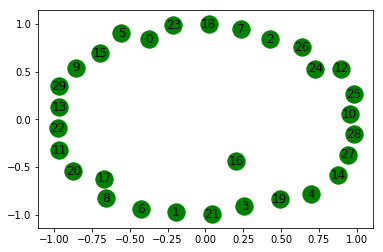

In [6]:
U = nx.empty_graph(30);
pos = nx.spring_layout(U);
nx.draw_networkx(U, pos, node_color='green');

[13 16 17 ... 22 26 24]


/home/alberto/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


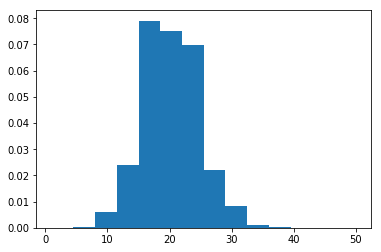

In [7]:
x = numpy.random.poisson(20, 20000000)
print(x)
count, bins, ignored = plt.hist(x, 14, normed=True)
plt.show()

[0.20319691 0.04710579 0.08212619 ... 0.21308118 0.11649242 0.08870249]


/home/alberto/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


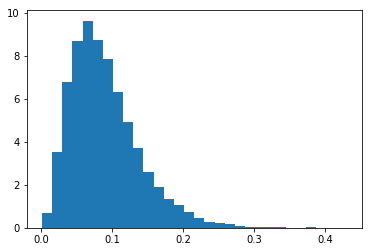

In [8]:
x = numpy.random.gamma(3.456,0.026,20000)
print(x)
count, bins, ignored = plt.hist(x, 30, normed=True)
plt.show()

[4.0, 6.0, 6.0, 5.0, 7.0, 6.0, 8.0, 4.0, 3.0, 5.0, 5.0, 10.0, 5.0, 5.0, 6.0, 4.0, 5.0, 4.0, 8.0, 3.0]


/home/alberto/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


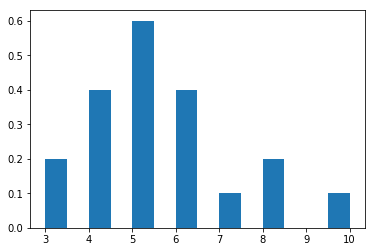

In [9]:
x = numpy.random.normal(5.9,2,20)
y = []
n=0
for i in x:
    i = round(i)
    y.append(i)
    n = n+1
    
print(y)
count, bins, ignored = plt.hist(y, 14, normed=True)
plt.show()

In [11]:
from soil import history

In [12]:
list(h.to_tuples())

NameError: name 'h' is not defined